### SHERLOCK EPISODE-1: IDENTITY FEATURE EXTRACTION

In [6]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import dlib
import face_recognition
import pliers

#### IMPORT VIDEO

In [7]:
### get stimuli
sherlock_video = 'stimuli_Sherlock.m4v'

### read video into pliers
from pliers.stimuli import VideoStim
video = VideoStim(sherlock_video)

### downsample video frames (1 frame/second)
from pliers.filters import FrameSamplingFilter
filt = FrameSamplingFilter(hertz=1)
selected_frames = filt.transform(video)
n_frames = selected_frames.n_frames

#### GET TIME SERIES OF FACES

In [10]:
# specify convolutional neural network extractor
from pliers.extractors import FaceRecognitionFaceLocationsExtractor
face_ext = FaceRecognitionFaceLocationsExtractor(model='cnn')

# detect faces in selected frames
face_features = face_ext.transform(selected_frames)

from pliers.extractors import merge_results
merged_faces = merge_results(face_features, metadata=False)

Stim: 1427it [1:09:11,  2.91s/it]


In [103]:
# see which frames have faces in them
face_frames = [f.data for f in selected_frames if f.onset in merged_faces.onset.tolist()]
n_face_frames = len(face_frames)

In [ ]:
nonface_frames = [f.data for f in selected_frames if f.onset not in merged_faces.onset.tolist()]
n_nonface_frames = len(nonface_frames)

In [12]:
### plot frames
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

### plot image grid function
def plot_img_grid(img_list, shape, figsize=(30., 30.)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.1)

    for ax, im in zip(grid, img_list):
        ax.imshow(im)

    plt.show()

plot_img_grid(face_frames[50:70], (5,4))
plot_img_grid(nonface_frames[50:70], (5,4))

#### CREATE AND SAVE PNGS OF EACH FACE FRAME

In [164]:
from PIL import Image

if not os.path.exists('faceframe_pngs'):
    os.makedirs('faceframe_pngs')
    
for num, frame in enumerate(selected_frames):
    
    if frame.onset in merged_faces.onset.tolist():

        img = Image.fromarray(frame.data, 'RGB')
        img.save('faceframe_pngs/frame_'+str(num)+'_time_'+str(int(frame.onset))+'s.png')

### USE FACE RECOGNITION PACKAGE TO COMPARE INDIVIDUALS

In [246]:
os.listdir('characters')[4:6]

['watson.png', 'sherlock.png']

In [289]:
import face_recognition

characters=os.listdir('characters')[4:6]
faceframes=os.listdir('faceframe_pngs')

face_recog = pd.DataFrame()
known_faces=[]
unknown_faces=[]
face_matches=[]

for character in characters:
    
    known_image = face_recognition.load_image_file(os.path.join('characters',character))
    known_encodings = face_recognition.face_encodings(known_image)[0] # add functionality for if >1 face, use face location data
    
    for frame in faceframes:
        
        unknown_image = face_recognition.load_image_file(os.path.join('faceframe_pngs',frame))
        if face_recognition.face_locations(unknown_image) != []:
            unknown_encodings = face_recognition.face_encodings(unknown_image)[0] # add functionality for if >1 face
            face_match = face_recognition.compare_faces([known_encodings], unknown_encodings)[0] # add functionality for if >1 face, use face location data

            known_faces.append(character)
            unknown_faces.append(frame)
            face_matches.append(face_match)

face_recog['known_face']=known_faces
face_recog['unknown_face']=unknown_faces
face_recog['face_match']=face_matches
face_recog.sort_values('unknown_face',ignore_index=True)

### PROJECT DATA BACK ONTO TIMESERIES DF

In [290]:
face_recog.loc[face_recog['face_match']==True]

,known_face,unknown_face,face_match
21,watson.png,frame_1033_time_1033s.png,True
28,watson.png,frame_122_time_122s.png,True
47,watson.png,frame_1151_time_1151s.png,True
51,watson.png,frame_534_time_534s.png,True
56,watson.png,frame_120_time_120s.png,True
...,...,...,...
886,sherlock.png,frame_1294_time_1294s.png,True
888,sherlock.png,frame_1242_time_1242s.png,True
899,sherlock.png,frame_1295_time_1295s.png,True
911,sherlock.png,frame_736_time_736s.png,True


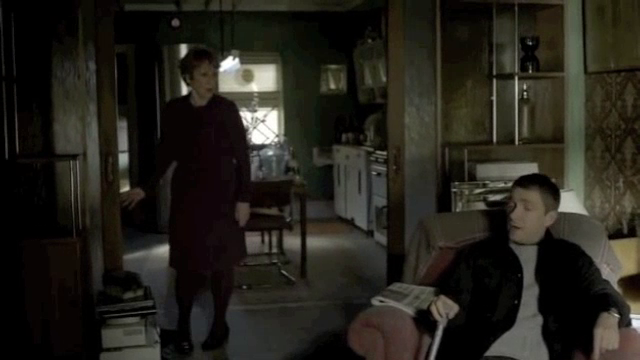

In [262]:
Image.fromarray(face_recognition.load_image_file(os.path.join('faceframe_pngs',face_recog['unknown_face'][19])),'RGB')

#### USE DEEP FACE TO COMPARE INDIVIDUALS

In [ ]:
### deepface to identify individuals
from deepface import DeepFace
result = DeepFace.verify(img1_path = "img1.jpg", img2_path = "img2.jpg")